## **Gamma Variation Heuristic**

In [1]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
# from qumcmc.energy_models import IsingEnergyFunction
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling

from qumcmc.classical_mcmc_routines import classical_mcmc
from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc     #for Qulacs Simulator backend (** Faster )
# from qumcmc.quantum_mcmc_routines_qiskit import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 

from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics


In [2]:
import pickle
import seaborn as sns
sns.set()

### **BAS Dataset** 

In [3]:
gridsize = 2
bas = bas_dataset(grid_size= gridsize); wts = hebbing_learning(bas.dataset)


In [4]:
# define the model
np.random.seed(610358)# should always be in the same cell!  ## best seed -> 610358
n_spins = gridsize*gridsize

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

#evaluating J for BAS dataset
J=-1*wts   #np.array([[0,0,0,4],[0,0,4,0],[0,4,0,0],[4,0,0,0]])

# defining h
h=np.zeros(np.shape(J)[0])

# instantiate the model
model=IsingEnergyFunction(J,h,name=f"BAS data of gridsize {gridsize}")

            MODEL : BAS data of gridsize 2
Non-zero Interactions (J) : 2 / 6
Non-zero Bias (h) : 0 / 4
---------------------------------------------
Average Interaction Strength <|J|> :  1.0
Average Bias Strength <|h|>:  0.0
alpha :  0.35355339059327373
---------------------------------------------


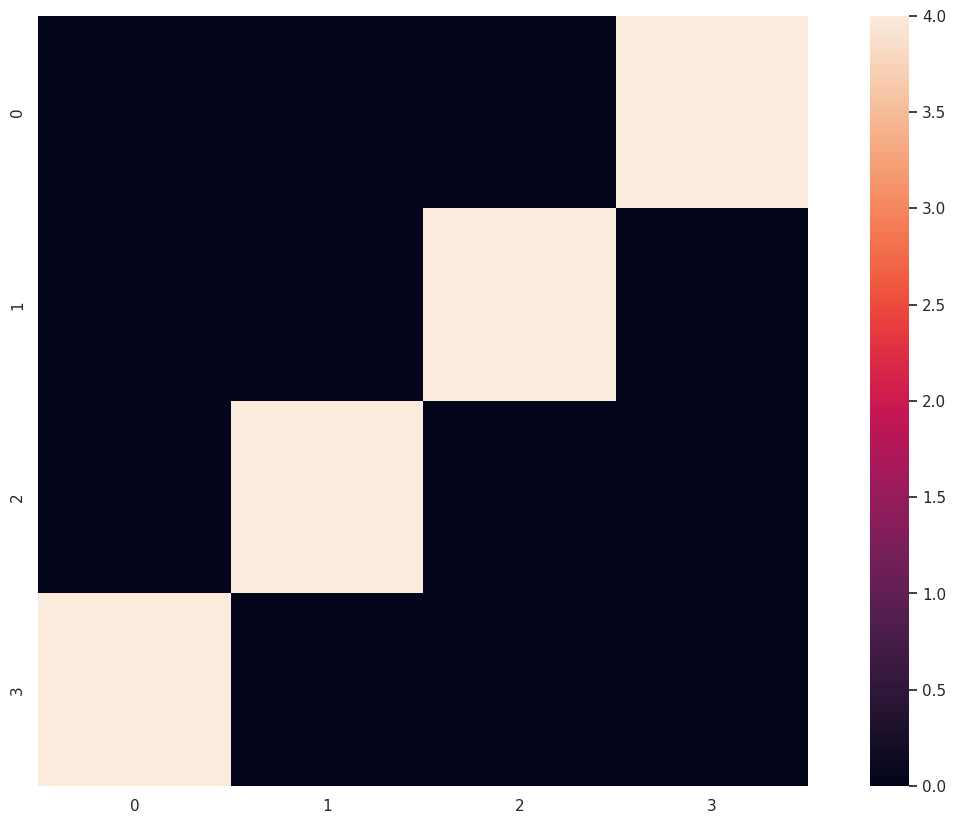

In [5]:
model.model_summary()

     MODEL : BAS data of gridsize 2 |  beta : 1
Num Most Probable States : 16
Entropy : 2.0087058847953743
---------------------------------------------


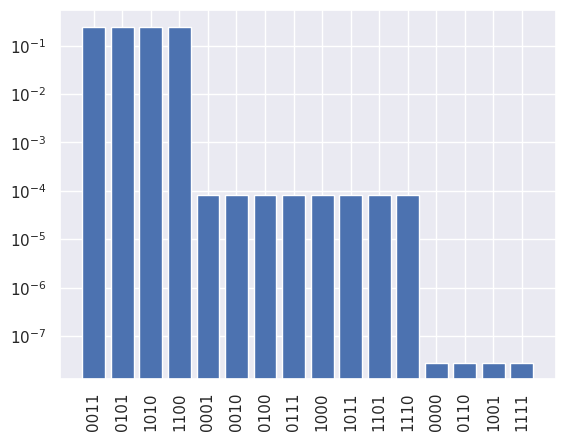

In [6]:
## set current beta
beta = 1#1.100209

## run exact sampling over all possible configurations 
exact_sampled_model = Exact_Sampling(model, beta)

## get the distribution from model
bpd = exact_sampled_model.boltzmann_pd

## exact sampling summary
exact_sampled_model.sampling_summary(show_threshold=1e-10)
plt.yscale("log")


#### **DECOY MODEL**

In [7]:
###
J_zero = np.zeros((n_spins, n_spins))

model_zero = IsingEnergyFunction(J_zero, h, name= 'zero-interaction-model')


/home/pafloxy/Documents/QBMS/quMCMC/qumcmc/energy_models.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  self.alpha = np.sqrt(self.num_spins) / np.sqrt( sum([J[i][j]**2 for i in range(self.num_spins) for j in range(i)]) + sum([h[j]**2 for j in range(self.num_spins)])  )


            MODEL : zero-interaction-model
Non-zero Interactions (J) : 0 / 6
Non-zero Bias (h) : 0 / 4
---------------------------------------------
Average Interaction Strength <|J|> :  0.0
Average Bias Strength <|h|>:  0.0
alpha :  inf
---------------------------------------------


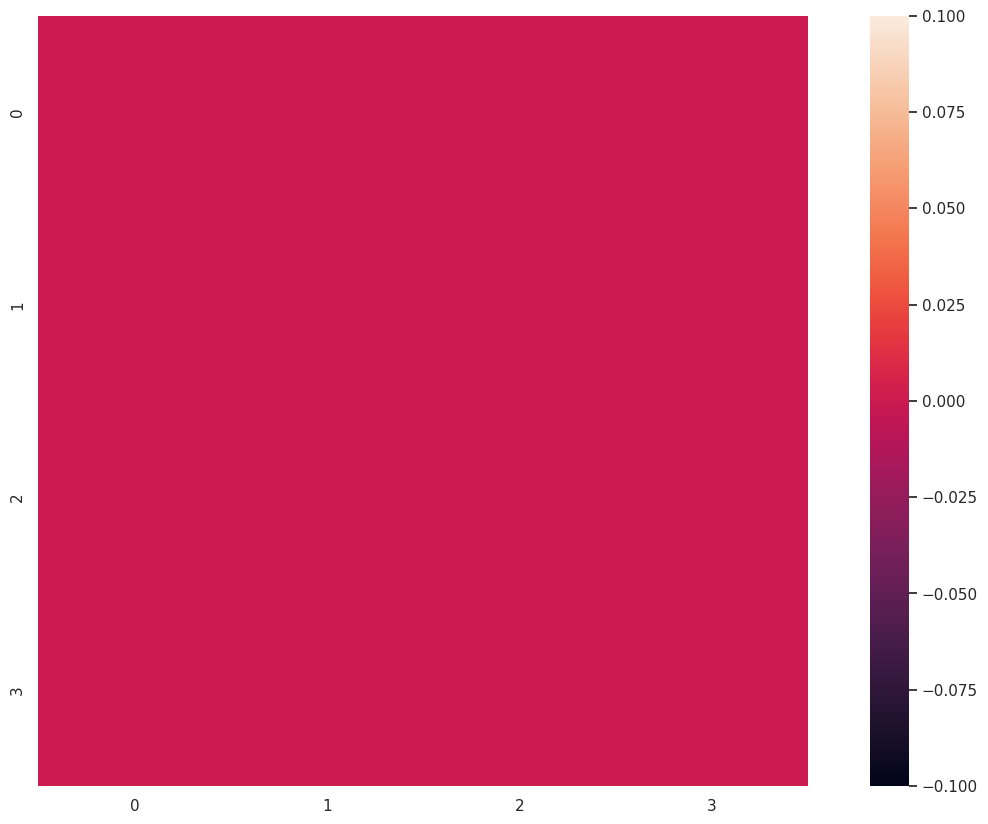

In [8]:
model_zero.model_summary();
model_zero_exact = Exact_Sampling(model_zero, beta);


In [9]:
# model = model_zero; exact_sampled_model = model_zero_exact

#### **quMCMC for gamma variation**

In [10]:
initial_state = bas.dataset[0]
steps= 10000

In [11]:
qmcmc_bmix_pertgamma = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    name = 'basic_mixer_pertgamma', gamma_range= (0.001, 0.1)
)

In [12]:
qmcmc_bmix_lowgamma = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    name = 'basic_mixer_lowgamma', gamma_range=(0.1,0.25)
)

In [13]:
qmcmc_bmix_medgamma = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    name = 'basic_mixer_medgamma', gamma_range=(0.3,0.65)
)

In [14]:
qmcmc_bmix_higamm = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    name = 'basic_mixer_higamma', gamma_range=(0.75, 1.00)
)

In [15]:
qmcmc_bmix_lowgamma.states

[MCMCState(bitstring='0101', accepted=True),
 MCMCState(bitstring='0101', accepted=True),
 MCMCState(bitstring='0101', accepted=True),
 MCMCState(bitstring='0101', accepted=True),
 MCMCState(bitstring='0101', accepted=True),
 MCMCState(bitstring='0101', accepted=True),
 MCMCState(bitstring='0101', accepted=True),
 MCMCState(bitstring='0101', accepted=True),
 MCMCState(bitstring='0101', accepted=True),
 MCMCState(bitstring='0101', accepted=True),
 MCMCState(bitstring='0101', accepted=True),
 MCMCState(bitstring='1100', accepted=True),
 MCMCState(bitstring='1100', accepted=True),
 MCMCState(bitstring='1100', accepted=True),
 MCMCState(bitstring='1100', accepted=True),
 MCMCState(bitstring='1101', accepted=False),
 MCMCState(bitstring='1100', accepted=True),
 MCMCState(bitstring='1100', accepted=True),
 MCMCState(bitstring='1100', accepted=True),
 MCMCState(bitstring='1100', accepted=True),
 MCMCState(bitstring='1100', accepted=True),
 MCMCState(bitstring='1100', accepted=True),
 MCMCStat

In [16]:
## Perturbative Gamma range : (0.001 -> 0.09)
qmcmc_advmix_pertgamma = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    gamma_range= (0.001, 0.09),
    single_qubit_mixer= False, pauli_index_list= [1]*gridsize,
    name= 'advmix_pertgamma'
)

In [17]:
## Low Gamma range : (0.1 -> 0.25)
qmcmc_advmix_lowgamma = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    gamma_range= (0.1, 0.25),
    single_qubit_mixer= False, pauli_index_list= [1]*gridsize,
    name= 'advmic_lowgamma'
)

In [18]:
## Medium Gamma range : (0.25 -> 0.75)
qmcmc_advmix_medgamma = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    gamma_range= (0.25, 0.75),
    single_qubit_mixer= False, pauli_index_list= [1]*gridsize,
    name= 'advmix_medgamma'
)

In [19]:
## High Gamma range : (0.75 -> 0.9)
qmcmc_advmix_higamma = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    gamma_range= (0.75, 0.9),
    single_qubit_mixer= False, pauli_index_list= [1]*gridsize,
    name= 'advmix_higamma'
)

In [20]:
## Extreme Gamma range : (0.9 -> 0.9999)
qmcmc_advmix_extgamma = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    gamma_range= (0.9, 0.9999),
    single_qubit_mixer= False, pauli_index_list= [1]*gridsize,
    name= 'advmix_extgamma'
)

In [21]:
## Extra trial ##

qmcmc_extra = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    gamma_range= (0.5,0.6),
    single_qubit_mixer= False, pauli_index_list= [1]*gridsize,
    name= 'advmix_extra'
)

#### **Analysis**

In [9]:
# qchains = [qmcmc_bmix_pertgamma, qmcmc_bmix_lowgamma, qmcmc_bmix_medgamma, qmcmc_bmix_higamm, qmcmc_advmix_pertgamma, qmcmc_advmix_lowgamma, qmcmc_advmix_medgamma, qmcmc_advmix_higamma, qmcmc_advmix_extgamma, qmcmc_extra]


# with open('SavedData/GammaVaraitionData/gv_qchains_v0.pickle', 'wb') as f:

#     pickle.dump( qchains ,f)


In [10]:
with open('SavedData/GammaVaraitionData/gv_qchains_v0.pickle', 'rb') as f:

    qchains = pickle.load(f)

In [10]:
kldivs = {}
for chain in qchains: kldivs[chain.name] = calculate_running_kl_divergence(exact_sampled_model.boltzmann_pd, chain)

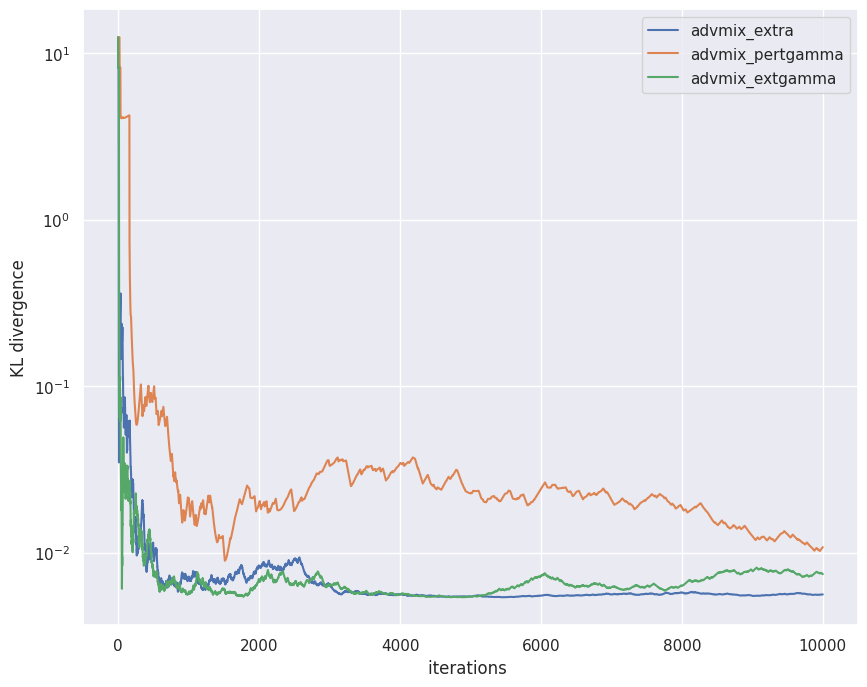

In [11]:
plt.figure(figsize=(10,8))

plt.plot(kldivs['advmix_extra'], label='advmix_extra')
plt.plot(kldivs['advmix_pertgamma'], label='advmix_pertgamma')
plt.plot(kldivs['advmix_extgamma'], label='advmix_extgamma')

plt.xlabel("iterations ")
plt.ylabel("KL divergence")
plt.yscale('log')
# plt.xscale("log")
plt.legend()
plt.show()

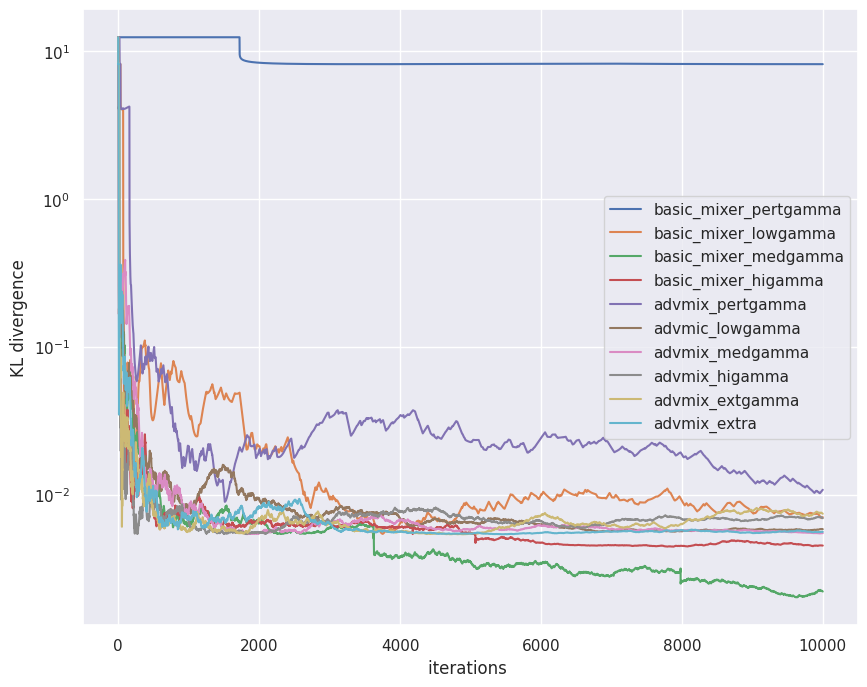

In [12]:
plt.figure(figsize=(10,8))

for items in list(kldivs.items()):
    plt.plot(items[1], label= items[0])

plt.xlabel("iterations ")
plt.ylabel("KL divergence")
plt.yscale('log')
# plt.xscale("log")
plt.legend()
plt.show()

In [11]:
trajectory_stat = {}
for chain in qchains : trajectory_stat[chain.name]  = get_trajectory_statistics(chain, exact_sampled_model)


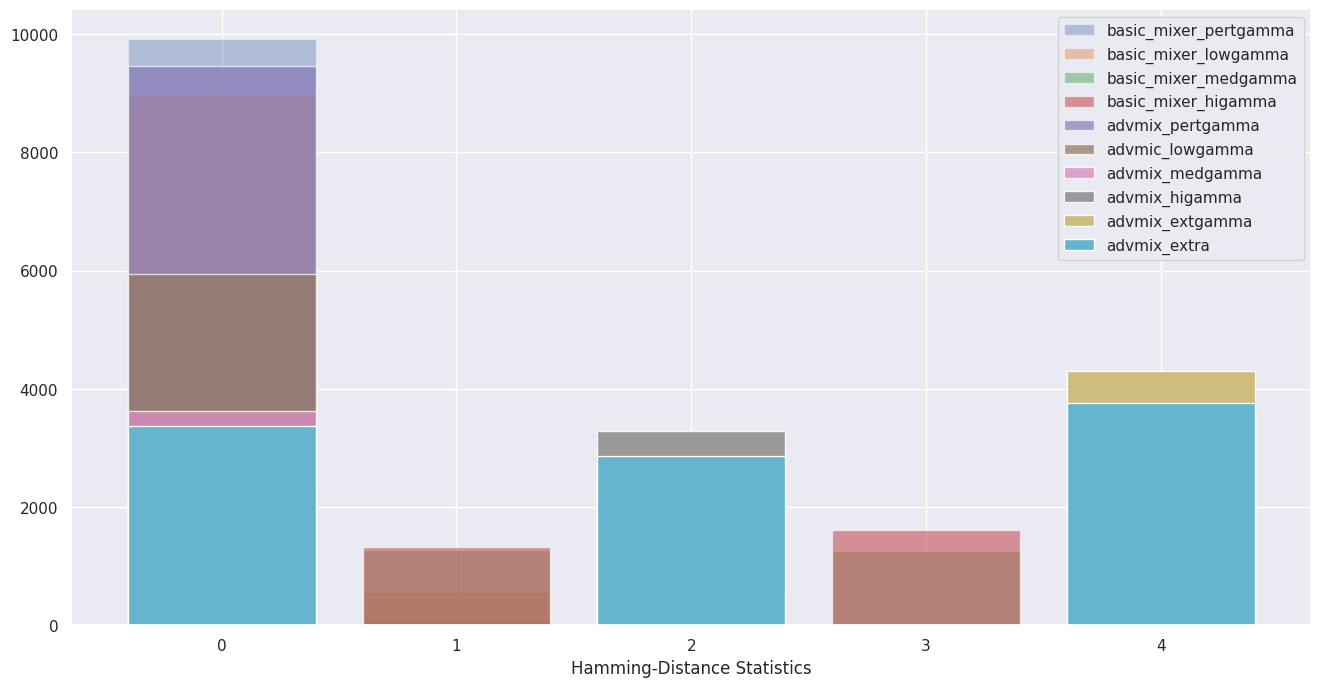

In [12]:
plot_hamming_distance_statistics(list(trajectory_stat.values()), nspin= n_spins,labels= list(trajectory_stat.keys()))

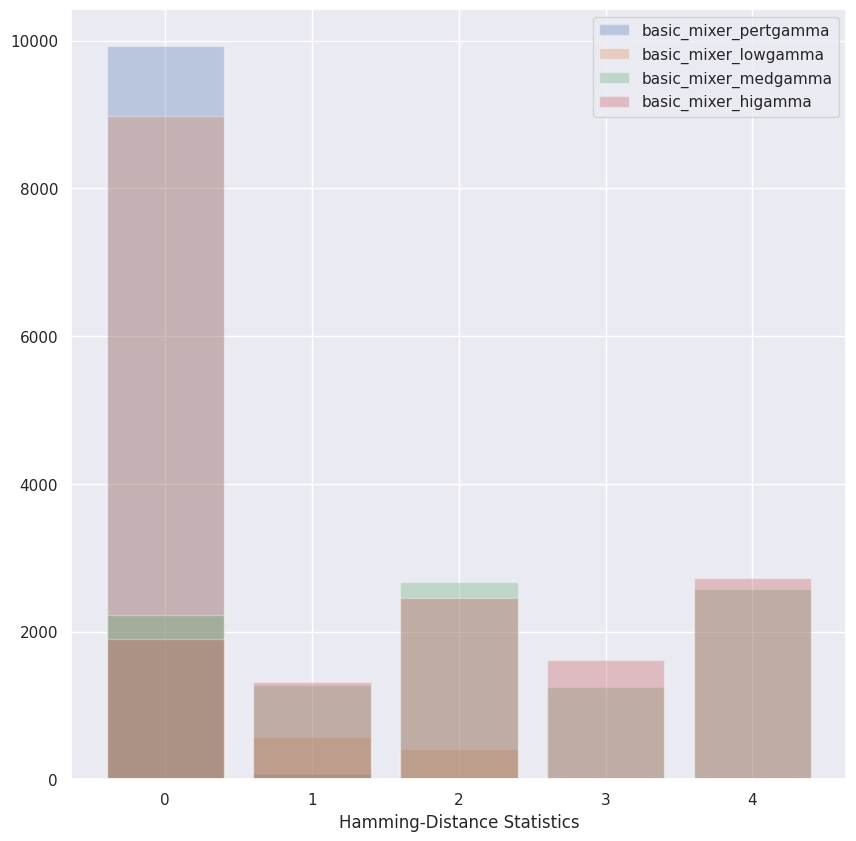

In [27]:
plt.figure(figsize=(10,10))

bins = np.arange(0, n_spins+1)

for item in list(trajectory_stat.items())[:4]:

    plt.bar(*np.unique(item[1]['hamming'], return_counts=True),label= item[0] ,alpha= 0.3)

# plt.xscale("log")

plt.xlabel("Hamming-Distance Statistics")
# plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

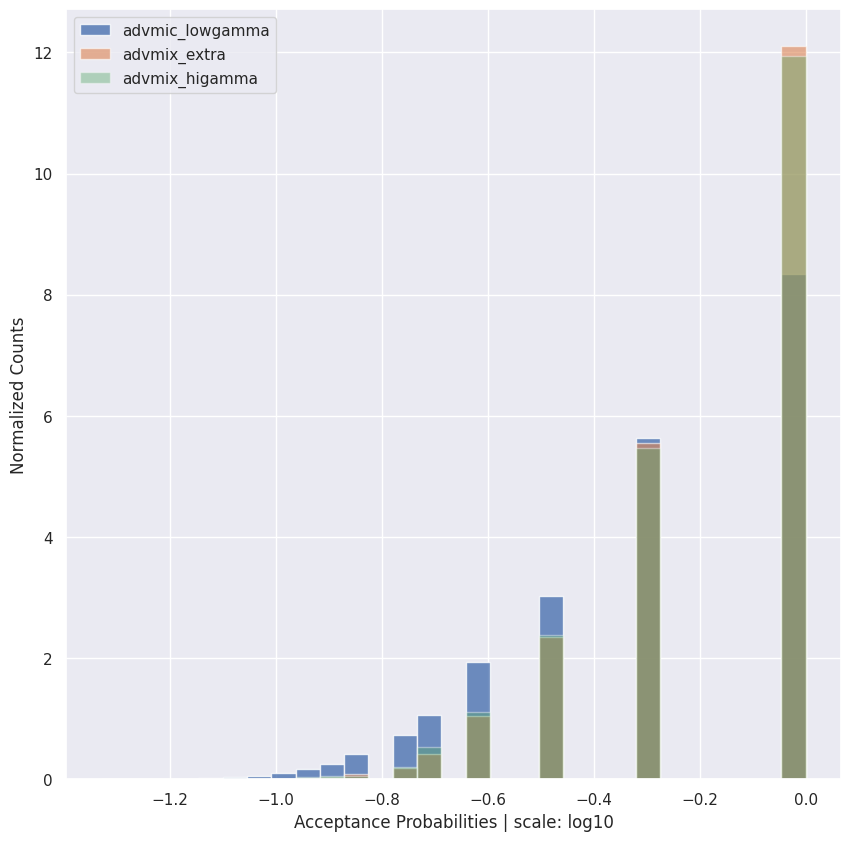

In [28]:
plt.figure(figsize=(10,10))

bins = np.linspace(np.log10(np.min([np.min(trajectory_stat['advmic_lowgamma']['acceptance_prob']),
                                    np.min(trajectory_stat['advmix_extra']['acceptance_prob']),
                                    np.min(trajectory_stat['advmix_extgamma']['acceptance_prob'])]))-0.1, 0, num=30)

plt.hist(np.log10(trajectory_stat['advmic_lowgamma']['acceptance_prob']),label= 'advmic_lowgamma' , alpha= 0.8, bins= bins, density=True)
plt.hist(np.log10(trajectory_stat['advmix_extra']['acceptance_prob']),label= 'advmix_extra' , alpha= 0.6, bins= bins, density=True)
plt.hist(np.log10(trajectory_stat['advmix_higamma']['acceptance_prob']),label= 'advmix_higamma' ,alpha= 0.4, bins= bins, density=True)


# plt.xscale("log")

plt.xlabel("Acceptance Probabilities | scale: log10")
plt.ylabel("Normalized Counts")
plt.legend()
plt.show()

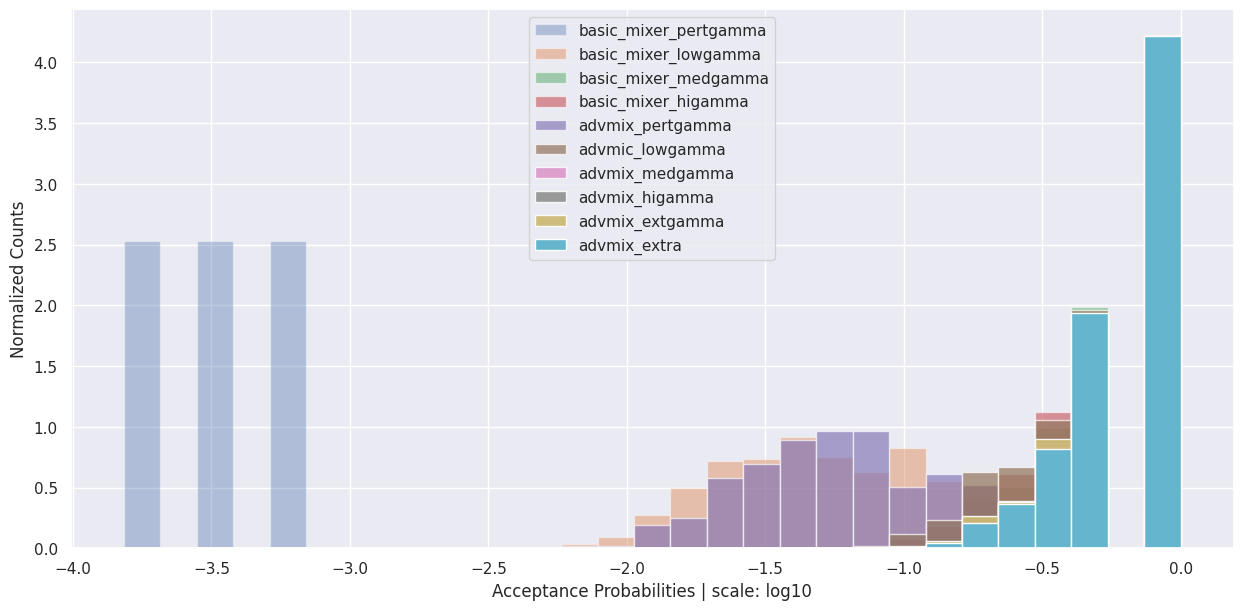

In [13]:
plot_acceptance_prob_statistics(list(trajectory_stat.values()), labels= list(trajectory_stat.keys()))